In [4]:
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [11]:
titanic_df = spark.read.csv('/datasets/titanic_original.csv', header=True, inferSchema=True)

In [14]:
titanic_df.limit(10).toPandas()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,None,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,None,C,None,22.0,"Montevideo, Uruguay"


In [15]:
# some basic cleanup
drop_cols = ['boat', 'body']
new_titanic_df = titanic_df.\
    drop(*drop_cols).\
    withColumnRenamed('home.dest', 'home_dest').\
    fillna('O').\
    dropna(subset=['pclass', 'age', 'sibsp', 'parch', 'fare', 'survived'])

In [16]:
training, test = new_titanic_df.randomSplit([0.8, 0.2], 0)

## classic pipeline

In [17]:
model0 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'],
                                        outputCol='features'),
                 classification.LogisticRegression(labelCol='survived', featuresCol='features')])

In [18]:
model0_fitted = model0.fit(training)

In [19]:
model0_fitted.transform(test).select(fn.avg(fn.expr('prediction = survived').cast('float'))).show()

+-------------------------------------------+
|avg(CAST((prediction = survived) AS FLOAT))|
+-------------------------------------------+
|                         0.6881188118811881|
+-------------------------------------------+



In [20]:
new_titanic_df.select(fn.avg('survived')).show()

+-------------------+
|      avg(survived)|
+-------------------+
|0.40861244019138754|
+-------------------+



In [21]:
evaluator = BinaryClassificationEvaluator(labelCol='survived')

In [22]:
evaluator.evaluate(model0_fitted.transform(test))

0.7558943089430892

If we wanted to modify the pipeline to add "sex" (gender) as a feature, we need to modify the point of entry and the next transformation

In [23]:
model1 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'],
                                        outputCol='features'),
                          feature.StringIndexer(inputCol='sex', outputCol='encoded_sex'),
                          feature.VectorAssembler(inputCols=['features', 'encoded_sex'], outputCol='final_features'),
                 classification.LogisticRegression(labelCol='survived', featuresCol='final_features')])

In [24]:
model1_fitted = model1.fit(training)

In [25]:
evaluator.evaluate(model1_fitted.transform(test))

0.8737296747967473

You can use the professor's package `pyspark_pipes` to do this more easily

In [35]:
!pip install git+https://github.com/daniel-acuna/pyspark_pipes.git

  Cloning https://github.com/daniel-acuna/pyspark_pipes.git to /tmp/pip-_9qb1_od-build
    100% |████████████████████████████████| 204kB 2.5MB/s ta 0:00:01
  Running setup.py install for pyspark-pipes ... done
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
# package that makes it easy to build pipelines
from pyspark_pipes import pipe

In [37]:
uber_model = pipe((feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare']),
      feature.StringIndexer(inputCol='sex')
     )      
      ,
     feature.VectorAssembler(),
     classification.LogisticRegression(labelCol='survived'))

In [38]:
uber_model_fitted = uber_model.fit(training)

In [39]:
uber_model_fitted.transform(test)

DataFrame[pclass: int, survived: int, name: string, sex: string, age: double, sibsp: int, parch: int, ticket: string, fare: double, cabin: string, embarked: string, home_dest: string, VectorAssembler_44f68a902aa07f318f35__output: vector, StringIndexer_4fbb967272f290aaa6b1__output: double, VectorAssembler_472c833cd5cc0fc82dbf__output: vector, LogisticRegression_4bd0a129f514f036a5e9__rawPrediction: vector, LogisticRegression_4bd0a129f514f036a5e9__probability: vector, LogisticRegression_4bd0a129f514f036a5e9__prediction: double]

# Automated evaluator

In [43]:
def binary_evaluation(model_pipeline, model_fitted, data):
    return BinaryClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(), 
                                rawPredictionCol=model_pipeline.getStages()[-1].getRawPredictionCol()).\
    evaluate(model_fitted.transform(data))

# Initial model

$$
p(survived = 1) = f(\text{pclass}, \text{age}, \text{sibsp}, \text{parch}, \text{fare})
$$

In [44]:
model1_pipeline = pipe(feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare']),
             classification.LogisticRegression(labelCol='survived'))

In [45]:
model1_fitted = model1_pipeline.fit(training)

In [46]:
binary_evaluation(model1_pipeline, model1_fitted, test)

0.7558943089430892

In [47]:
model1_fitted.stages[-1].coefficients

DenseVector([-0.9888, -0.0377, -0.269, 0.2647, 0.0029])

In [48]:
model1_fitted.stages[-1].intercept

2.811419990637693

# Some preprocessing of the data

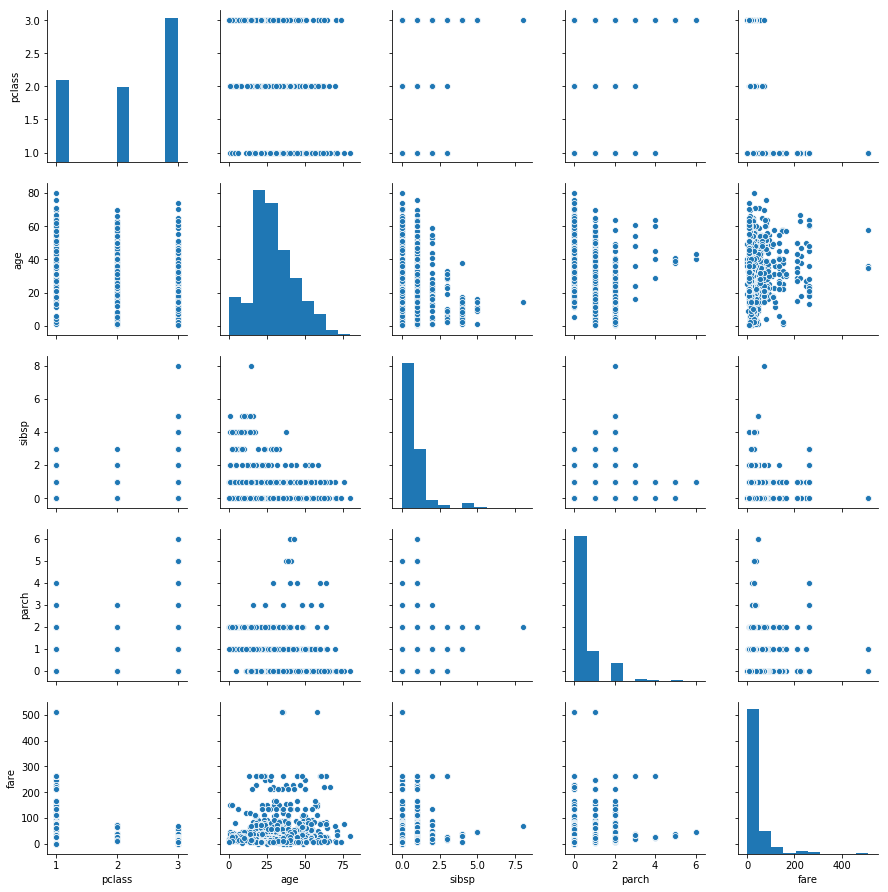

In [49]:
sns.pairplot(new_titanic_df.toPandas()[['pclass', 'age', 'sibsp', 'parch', 'fare']])

In [50]:
import numpy as np

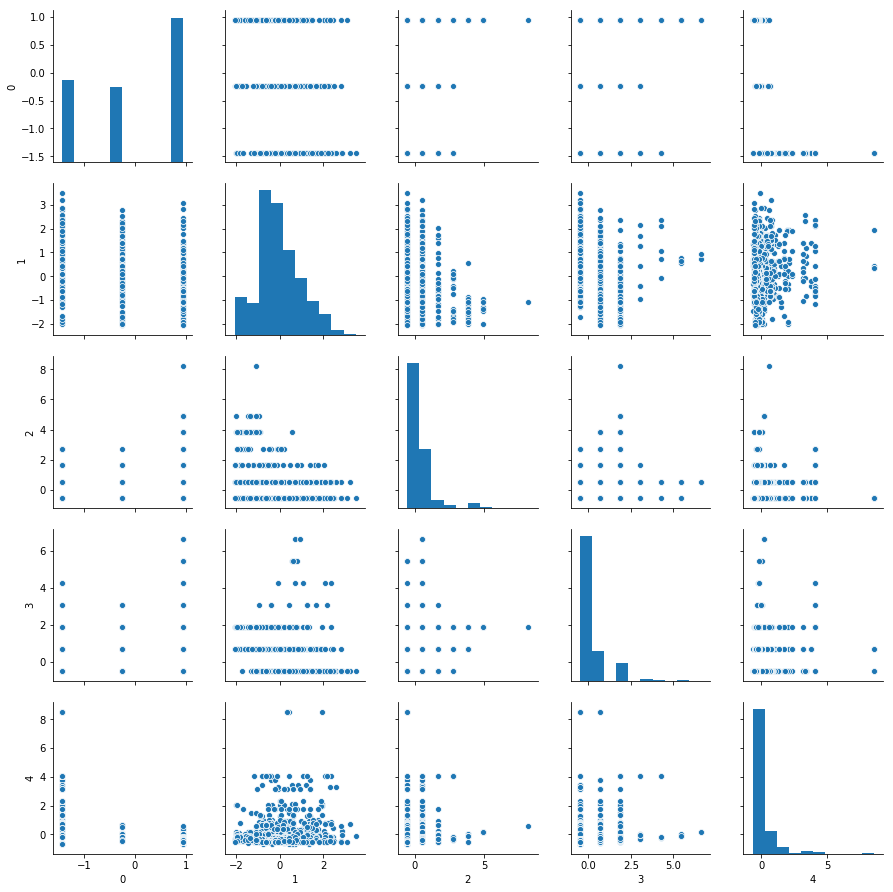

In [51]:
sns.pairplot(pd.DataFrame(np.vstack(pipe(feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare']),
    feature.StandardScaler(withMean=True)).fit(new_titanic_df).transform(new_titanic_df).toPandas().iloc[:, -1])))

Text(0.5,0,'age')

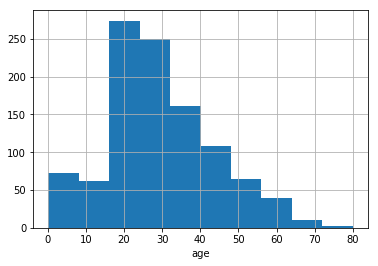

In [52]:
new_titanic_df.toPandas()[['pclass', 'age', 'sibsp', 'parch', 'fare']].age.hist()
plt.xlabel('age')

Text(0.5,0,'age')

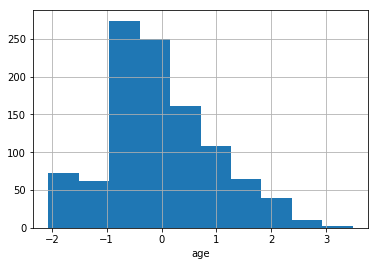

In [53]:
d = pd.DataFrame(np.vstack(pipe(feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare']),
    feature.StandardScaler(withMean=True)).fit(new_titanic_df).transform(new_titanic_df).toPandas().iloc[:, -1]))
d.columns = ['pclass', 'age', 'sibsp', 'parch', 'fare']
d.age.hist()
plt.xlabel('age')

## Initial model on standardized results

In [54]:
model2_pipeline = pipe(feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare']),
              feature.StandardScaler(withMean=True),
             classification.LogisticRegression(labelCol='survived'))

In [55]:
model2_fitted = model2_pipeline.fit(training)

In [56]:
binary_evaluation(model1_pipeline, model1_fitted, test)

0.7558943089430892

In [57]:
binary_evaluation(model2_pipeline, model2_fitted, test)

0.7558943089430892

In [58]:
model2_fitted.stages[-1].intercept

-0.4096876472113034

In [59]:
model2_fitted.stages[-1].coefficients

DenseVector([-0.8346, -0.5404, -0.244, 0.2177, 0.1636])

## other scaling

Text(0.5,0,'age')

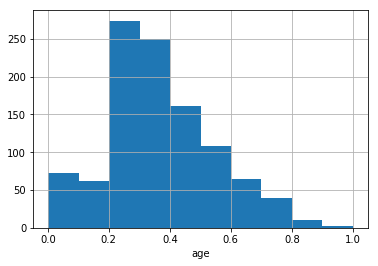

In [61]:
d = pd.DataFrame(np.vstack(pipe(feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare']),
    feature.MaxAbsScaler()).fit(new_titanic_df).transform(new_titanic_df).toPandas().iloc[:, -1]))
d.columns = ['pclass', 'age', 'sibsp', 'parch', 'fare']
d.age.hist()
plt.xlabel('age')

# Bucketizer

Text(0.5,0,'fare')

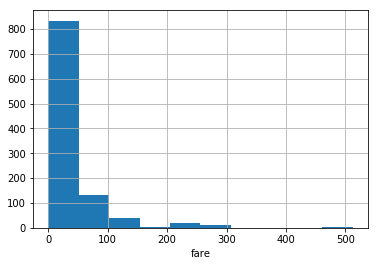

In [63]:
new_titanic_df.toPandas()[['pclass', 'age', 'sibsp', 'parch', 'fare']].fare.hist()
plt.xlabel('fare')

Text(0.5,0,'Fare bucket')

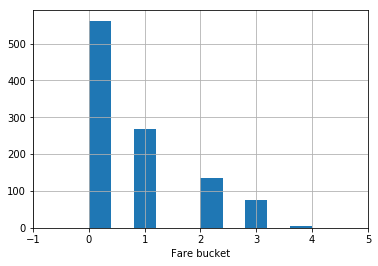

In [64]:
feature.Bucketizer(splits=[0, 20, 50, 100, 400, 800], inputCol='fare').transform(new_titanic_df).toPandas().iloc[:, -1].hist()
plt.xticks([-1, 0, 1, 2, 3, 4, 5]);
plt.xlabel('Fare bucket')

In [65]:
qd = feature.QuantileDiscretizer(numBuckets=4, inputCol='fare').fit(new_titanic_df)

In [66]:
qd.getSplits()

[-inf, 8.05, 15.75, 35.5, inf]

Text(0.5,0,'Fare quantiles')

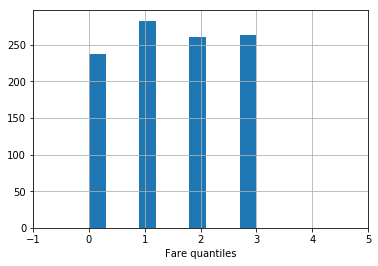

In [67]:
feature.QuantileDiscretizer(numBuckets=4, inputCol='fare').fit(new_titanic_df).transform(new_titanic_df).toPandas().iloc[:, -1].hist()
plt.xticks([-1, 0, 1, 2, 3, 4, 5]);
plt.xlabel('Fare quantiles')

Text(0.5,0,'age')

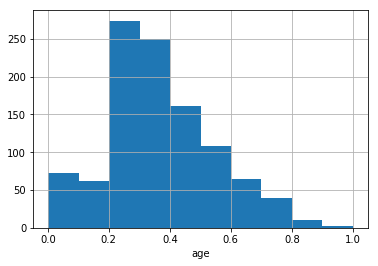

In [68]:
d = pd.DataFrame(np.vstack(pipe(feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare']),
    feature.MaxAbsScaler()).fit(new_titanic_df).transform(new_titanic_df).toPandas().iloc[:, -1]))
d.columns = ['pclass', 'age', 'sibsp', 'parch', 'fare']
d.age.hist()
plt.xlabel('age')

Text(0.5,0,'age')

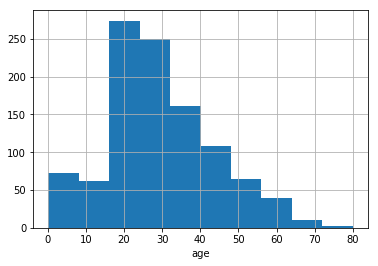

In [69]:
new_titanic_df.toPandas().age.hist()
plt.xlabel('age')

In [70]:
# full model

In [71]:
gender_pipe = feature.StringIndexer(inputCol='sex', handleInvalid='skip')

In [72]:
titles_list = " Capt  Col  Don  Dona  Dr  Jonkheer  Lady  Major  Master  Miss  Mlle  Mme  Mr  Mrs  Ms  Rev  Sir".lower().split()

In [73]:
title_pipe = pipe(feature.RegexTokenizer(pattern="\\b(" + ("|".join(titles_list)) + ")\\b", 
                       gaps=False,
                      inputCol='name'), 
                  feature.CountVectorizer())

In [74]:
new_titanic_df.select('embarked').distinct().show()

+--------+
|embarked|
+--------+
|       Q|
|       O|
|       C|
|       S|
+--------+



In [75]:
embarked_pipe = pipe(feature.StringIndexer(inputCol='embarked', handleInvalid='skip'), feature.OneHotEncoder())

In [77]:
embarked_pipe.fit(new_titanic_df.select('embarked')).transform(new_titanic_df.select('embarked')).distinct().show()

+--------+------------------------------------------+------------------------------------------+
|embarked|StringIndexer_44ba85ff58bb063434a9__output|OneHotEncoder_42be9470e3a0443bcbb1__output|
+--------+------------------------------------------+------------------------------------------+
|       Q|                                       2.0|                             (3,[2],[1.0])|
|       C|                                       1.0|                             (3,[1],[1.0])|
|       S|                                       0.0|                             (3,[0],[1.0])|
|       O|                                       3.0|                                 (3,[],[])|
+--------+------------------------------------------+------------------------------------------+



In [78]:
cabin_pipe = Pipeline(stages=[feature.SQLTransformer(statement='select *, substring(cabin,1,1) as cabin_col from __THIS__'),
                              feature.StringIndexer(inputCol='cabin_col', outputCol='cabin_col2', handleInvalid='skip'),
                              feature.OneHotEncoder(inputCol='cabin_col2')])

In [79]:
numerical_features = pipe(feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch']),
                          feature.StandardScaler())

In [80]:
all_features = pipe((numerical_features, feature.QuantileDiscretizer(inputCol='fare', numBuckets=4), gender_pipe, title_pipe, embarked_pipe, cabin_pipe), feature.VectorAssembler())

In [81]:
lr = classification.LogisticRegression(labelCol='survived')

In [82]:
final_model_pipeline = pipe(all_features, lr)

In [83]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .build()

In [84]:
len(paramGrid)

12

In [85]:
evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)

In [86]:
final_model_fitted = crossval.fit(training)

In [87]:
test.show()

+------+--------+--------------------+------+----+-----+-----+----------+--------+-------+--------+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|    ticket|    fare|  cabin|embarked|           home_dest|
+------+--------+--------------------+------+----+-----+-----+----------+--------+-------+--------+--------------------+
|     1|       0|"Lindeberg-Lind, ...|  male|42.0|    0|    0|     17475|   26.55|      O|       S|   Stockholm, Sweden|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|    113781|  151.55|C22 C26|       S|Montreal, PQ / Ch...|
|     1|       0|Andrews, Mr. Thom...|  male|39.0|    0|    0|    112050|     0.0|    A36|       S|         Belfast, NI|
|     1|       0|Clark, Mr. Walter...|  male|27.0|    1|    0|     13508|136.7792|    C89|       C|     Los Angeles, CA|
|     1|       0|Colley, Mr. Edwar...|  male|47.0|    0|    0|      5727| 25.5875|    E58|       S|        Victoria, BC|
|     1|       0|Cumings, Mr. Jo

In [88]:
evaluator.evaluate(final_model_fitted.transform(test))

0.9018292682926831

In [89]:
b = final_model_fitted.bestModel.stages[1]

In [90]:
b.getInputCol()

'fare'

In [91]:
b.getSplits()

[-inf, 8.05, 15.85, 512.3292, inf]

In [92]:
final_model_fitted.bestModel.stages[-1].coefficients

DenseVector([-0.6786, -0.412, -0.3381, -0.1129, -0.1433, 1.4663, -0.5354, 0.4138, 1.2189, 1.6237, -2.2867, 0.9766, 0.3034, 0.448, 1.2078, 1.3384, 2.0119, -3.4518, 2.8539, -2.2494, 1.361, -3.116, 0.1322, 0.8618, -0.3476, 0.0822, 0.2063, 0.7286, 0.7238, 1.3382, 0.4811, 0.5391, -0.0067])

In [93]:
final_model_fitted.bestModel.stages[0].stages[0].getInputCols()

['pclass', 'age', 'sibsp', 'parch']

In [94]:
final_model_fitted.bestModel.stages[1]

Bucketizer_4bf986685ed282063fa0

In [95]:
final_model_fitted.bestModel.stages[1].getInputCol()

'fare'

In [96]:
final_model_fitted.bestModel.stages[1].getInputCol()

'fare'

In [98]:
si = final_model_fitted.bestModel.stages[2]

In [99]:
si.labels

['male', 'female']

In [100]:
final_model_fitted.bestModel.stages[3].stages[1].vocabulary

['mr',
 'miss',
 'mrs',
 'master',
 'rev',
 'dr',
 'col',
 'major',
 'mlle',
 'lady',
 'dona',
 'don',
 'ms',
 'capt',
 'mme',
 'jonkheer']

In [101]:
len(final_model_fitted.bestModel.stages[-1].coefficients)

33

In [102]:
final_model_fitted.bestModel.stages[-1]

LogisticRegression_4fefa021932c0a86ace9

In [103]:
final_model_fitted.bestModel.stages[-1].coefficients

DenseVector([-0.6786, -0.412, -0.3381, -0.1129, -0.1433, 1.4663, -0.5354, 0.4138, 1.2189, 1.6237, -2.2867, 0.9766, 0.3034, 0.448, 1.2078, 1.3384, 2.0119, -3.4518, 2.8539, -2.2494, 1.361, -3.116, 0.1322, 0.8618, -0.3476, 0.0822, 0.2063, 0.7286, 0.7238, 1.3382, 0.4811, 0.5391, -0.0067])

In [104]:
lr_fit = final_model_fitted.bestModel.stages[-1]

In [105]:
lr_fit.summary.featuresCol

'VectorAssembler_47b3b3a2ae63aca55ca1__output'

In [106]:
final_model_fitted.bestModel.stages[0].stages

[VectorAssembler_4587a64b8a4c65716ea0, StandardScaler_473f8b4cd5b540a4a01b]